In [1]:
import pandas as pd
import string, re
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve

C:\Users\Kuba\Documents\py_interpreter2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv("data/subtask-2-english/train_en.tsv",sep='\t')
dev_data = pd.read_csv("data/subtask-2-english/dev_en.tsv", sep='\t')


In [3]:
# Mapping label strings to integers
label_map = {"OBJ": 0, "SUBJ": 1}
train_data['label'] = train_data['label'].map(label_map)
print(train_data['label'])

dev_data['label'] = dev_data['label'].map(label_map)
print(dev_data['label'])

0      1
1      0
2      0
3      0
4      1
      ..
825    1
826    1
827    1
828    1
829    1
Name: label, Length: 830, dtype: int64
0      1
1      1
2      0
3      0
4      0
      ..
214    1
215    1
216    1
217    1
218    0
Name: label, Length: 219, dtype: int64


In [4]:
train_data = train_data.drop('solved_conflict', axis=1)

In [5]:
train_data

,sentence_id,sentence,label
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,1
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,0
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,0
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,0
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",1
...,...,...,...
825,9a0f5eec-cc36-49b8-88eb-20ad2c056eaa,Local governments and their financing vehicles...,1
826,73545884-adf8-480c-a8b5-e65128ba8e91,That fact alone underscores the biggest proble...,1
827,a8825286-21a4-46c9-9410-c0e7e183d708,Presumably it had in mind those Russian offici...,1
828,c984fc97-2604-4690-a2c0-d748703663af,"From bad taxation, reckless borrowing and reck...",1


In [6]:
# Load tokenizer
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [7]:
train_encodings = tokenizer(train_data['sentence'].tolist(), truncation=True, padding=True)
eval_encodings = tokenizer(dev_data['sentence'].tolist(), truncation=True, padding=True)

In [8]:
#train_encodings["input_ids"]
#train_encodings["attention_mask"]


In [9]:
# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_data['label'])
)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(eval_encodings['input_ids']),
    torch.tensor(eval_encodings['attention_mask']),
    torch.tensor(dev_data['label'])
)

In [10]:
print(train_dataset[0][0].shape) # input_ids shape
print(train_dataset[0][1].shape) # attention_mask shape
print(train_dataset[0][2].shape) # train_labels_onehot shape

torch.Size([158])
torch.Size([158])
torch.Size([])


In [11]:
# Define model
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-large', num_labels=2)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
#device

In [13]:
# trainer parameters
epochs = 5
learning_rate=5e-5 #5e-5 default 3e-5 5e-6, 1e-5, 3e-5, 5e-5

In [14]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=25,
    learning_rate=learning_rate,
)

In [15]:
# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'labels': torch.stack([item[2] for item in data])},
)

C:\Users\Kuba\Documents\py_interpreter2\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss
25,0.635700,0.765326
50,0.658300,0.760598
75,0.689400,0.737698
100,0.576900,0.699890
125,0.584000,0.628803
150,0.668600,0.596336
175,0.483700,0.611864
200,0.443100,1.042045
225,0.341400,0.584499
250,0.320200,0.657791


TrainOutput(global_step=260, training_loss=0.5497405794950632, metrics={'train_runtime': 3158.869, 'train_samples_per_second': 1.314, 'train_steps_per_second': 0.082, 'total_flos': 1193491005730800.0, 'train_loss': 0.5497405794950632, 'epoch': 5.0})

In [17]:
model.num_parameters()

559892482

In [18]:
#model.save_pretrained("./model")

In [19]:
#model = XLMRobertaForSequenceClassification.from_pretrained("./model")

In [20]:
# test
test_data = pd.read_csv("data/subtask-2-english/dev_test_en.tsv", sep='\t')  # Update with your dev data file
test_data['label'] = test_data['label'].map(label_map)
test_encodings = tokenizer(test_data['sentence'].tolist(), truncation=True, padding=True)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_data['label'])
)

In [21]:
preds = trainer.predict(test_dataset)
pred_labels = preds.predictions.argmax(-1)



In [22]:
print(pred_labels)

[1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1
 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1
 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1
 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0
 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0]


In [23]:
# Convert the true labels to integers

# Compute the accuracy and classification report
accuracy = accuracy_score(test_data['label'], pred_labels)
class_report = classification_report(test_data['label'], pred_labels, target_names=['OBJ', 'SUBJ'])

print(f"Accuracy for RoBERTa: {accuracy}")
print(f"Classification Report:\n{class_report}")

Accuracy for RoBERTa: 0.7983539094650206
Classification Report:
              precision    recall  f1-score   support

         OBJ       0.77      0.82      0.79       116
        SUBJ       0.82      0.78      0.80       127

    accuracy                           0.80       243
   macro avg       0.80      0.80      0.80       243
weighted avg       0.80      0.80      0.80       243



In [24]:
# learning rate 5e-5
# epochs 3 - acc 0.61 - OBJ 0.55, SUBJ 0.94 - f1 0.71 - 0.42
# epochs 10 - BROKE
# epochs 2  - acc 0.61 - OBJ 0.56, SUBJ 0.71 - f1 0.66 - 0.54
# epochs 4  - acc 0.70 - OBJ 0.67, SUBJ 0.74 - f1 0.70 - 0.70 ovrft?
# epochs 5  - acc 0.79 - OBJ 0.85, SUBJ 0.75 - f1 0.76 - 0.82 overfitting? increasing valid loss

#learning rate 5e-3
# epochs 3 - acc 0.61 - OBJ 0.55, SUBJ 0.94 - f1 0.71 - 0.42
# epochs 4 - acc 0.70 - OBJ 0.62, SUBJ 0.91 - f1 0.75 - 0.63 ovrft?

In [25]:
precision, recall, thresholds = precision_recall_curve(test_data['label'], pred_labels)

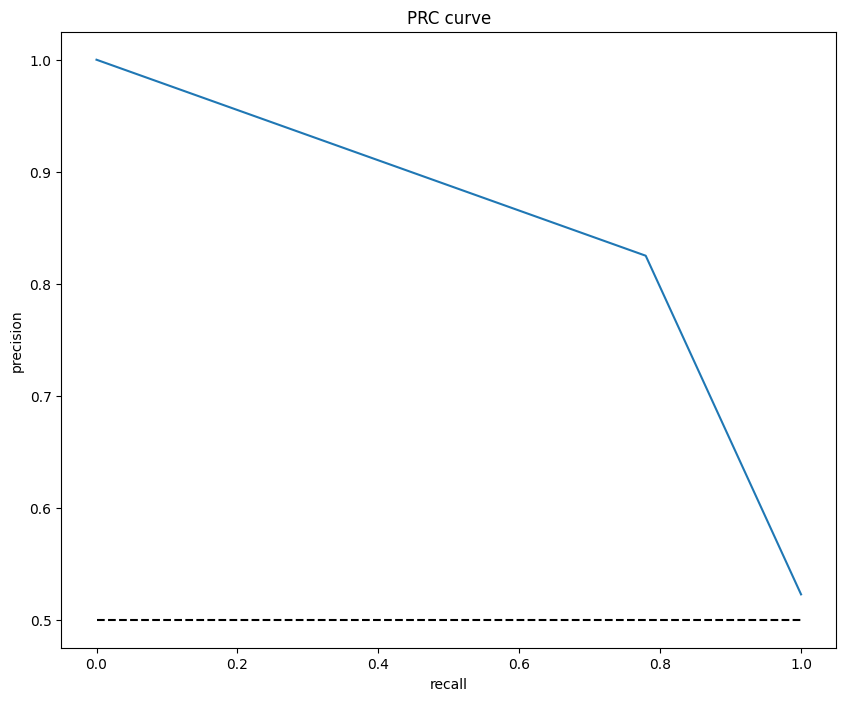

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall, precision, label = 'Knn')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.show()